In [296]:
import dask
dask.config.set({"dataframe.query-planning": False})

import anndata
import itertools
import scanpy as sc
import gseapy
import liana
import scipy
import numpy as np
import pandas as pd
import sys
import argparse
import json
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from typing import Dict, Optional, List

sys.path.append("../../../workflow/scripts/")
import readwrite
cfg = readwrite.config()
sns.set_style('ticks')


def _read_count_correction_sample(sample_name, corrected_counts_path):
    """Reads a 10x h5 file using scanpy."""
    try:
        adata = sc.read_10x_h5(corrected_counts_path)
        return sample_name, adata
    except Exception as e:
        print(f"Error reading {corrected_counts_path}: {e}")
        return sample_name, None  # Return None in case of an error

def read_count_correction_samples(xenium_paths,correction_methods):
    """
    Reads corrected count samples in parallel using ThreadPoolExecutor.

    Args:
        xenium_paths (dict): A dictionary where keys are correction methods and values are dictionaries
                            mapping sample names to corrected counts file paths.  Assumes `xenium_paths[correction_method]`
                            is a dictionary with keys as sample_name and values as path to the .h5 file.
        correction_methods (list): A list of correction methods.
    Returns:
        dict: A dictionary where keys are correction methods, and values are dictionaries mapping sample names
              to AnnData objects (or None if reading failed).
    """

    xenium_corrected_counts = {}

    for correction_method in correction_methods:  # Skip the first correction method
        xenium_corrected_counts[correction_method] = {}

        with ThreadPoolExecutor() as executor:
            futures = {
                executor.submit(_read_count_correction_sample, sample_name, xenium_corr_path): (correction_method, sample_name)
                for sample_name, xenium_corr_path in xenium_paths[correction_method].items()
            }

            # Progress bar with total number of samples
            for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {correction_method}"):
                try:
                    sample_name, adata = future.result()
                    if adata is not None:
                        xenium_corrected_counts[correction_method][sample_name] = adata
                    else:
                         xenium_corrected_counts[correction_method][sample_name] = None
                except Exception as e:
                    correction_method, sample_name = futures[future]
                    xenium_corrected_counts[correction_method][sample_name] = None  # Store None in case of error

    return xenium_corrected_counts


def read_diffexpr_results_sample(
    results_dir: Path,
    reference: str,
    method: str,
    level: str,
    mixture_k: int,
    num_samples: int,
    correction_method: str,
    segmentation: Path,
    condition: Path,
    panel: Path,
    donor: Path,
    sample: Path,
    normalisation: str,
    layer: str,
):
    """
    Reads differential expression results for a single sample.

    Args:
        results_dir (Path): Path to the results directory.
        reference (str): Reference string.
        method (str): Method string.
        level (str): Level string.
        mixture_k (int): Mixture K value.
        num_samples (int): Number of samples.
        correction_method (str): The correction method used.
        segmentation (Path): Path to the segmentation directory.
        condition (Path): Path to the condition directory.
        panel (Path): Path to the panel directory.
        donor (Path): Path to the donor directory.
        sample (Path): Path to the sample directory.
        normalisation (str): The normalisation method used.
        layer (str): The layer used.

    Returns:
        tuple: (correction_method, tuple of keys, DataFrame) if the file exists and is successfully read,
               otherwise None.
    """

    k = (segmentation.stem, condition.stem, panel.stem, donor.stem, sample.stem)
    name = '/'.join(k)

    if correction_method == 'raw':
        out_file_df_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_diffexpr.parquet'
        out_file_df_markers_rank_significance_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_markers_rank_significance_diffexpr.parquet'
    else:
        if correction_method == "resolvi":
            name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
        elif correction_method == "resolvi_supervised":
            name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
        elif "ovrlpy" in correction_method:
            name_corrected = f'{name}'

        out_file_df_diffexpr = results_dir / f'contamination_metrics_diffexpr_corrected_counts/{correction_method}/{name_corrected}/{normalisation}/{layer}_{reference}_{method}_{level}_diffexpr.parquet'
        out_file_df_markers_rank_significance_diffexpr = results_dir / f'contamination_metrics_diffexpr_corrected_counts/{correction_method}/{name_corrected}/{normalisation}/{layer}_{reference}_{method}_{level}_markers_rank_significance_diffexpr.parquet'

    if out_file_df_markers_rank_significance_diffexpr.exists():
        print(correction_method, k, end='\n')
        try:
             df = pd.read_parquet(out_file_df_markers_rank_significance_diffexpr, engine="pyarrow")
             return correction_method, k, df
        except Exception as e:
            print(f"Error reading {out_file_df_markers_rank_significance_diffexpr}: {e}")
            return None
    else:
        print("File does not exist:", out_file_df_diffexpr)
        return None

def read_diffexpr_results_samples(
    results_dir: Path,
    correction_methods: list[str],
    xenium_std_seurat_analysis_dir: Path,
    reference: str,
    method: str,
    level: str,
    mixture_k: int,
    num_samples: int,
    normalisation: str,
    layer: str,
):
    """
    Reads differential expression results for multiple samples in parallel.

    Args:
        results_dir (Path): Path to the results directory.
        correction_methods (list): List of correction methods to process.
        xenium_std_seurat_analysis_dir (Path): Path to the analysis directory.
        reference (str): Reference string.
        method (str): Method string.
        level (str): Level string.
        mixture_k (int): Mixture K value.
        num_samples (int): Number of samples.
        normalisation (str): The normalisation method used.
        layer (str): The layer used.

    Returns:
        dict: A dictionary where keys are correction methods, and values are dictionaries mapping sample keys
              to DataFrames.
    """

    df_markers_rank_significance_diffexpr = {correction_method: {} for correction_method in correction_methods}

    with ThreadPoolExecutor() as executor:
        futures = []
        for correction_method in correction_methods:
            for segmentation in xenium_std_seurat_analysis_dir.iterdir():
                if segmentation.stem == 'proseg_mode':
                    continue
                for condition in segmentation.iterdir():
                    for panel in condition.iterdir():
                        for donor in panel.iterdir():
                            for sample in donor.iterdir():
                                futures.append(executor.submit(
                                    read_diffexpr_results_sample,
                                    results_dir,reference,method,level,mixture_k,num_samples,correction_method,
                                    segmentation,condition,panel,donor,sample,normalisation,layer,
                                ))

        for future in as_completed(futures):
            result = future.result()
            if result:
                correction_method, k, df = result
                df_markers_rank_significance_diffexpr[correction_method][k] = df

    return df_markers_rank_significance_diffexpr


def get_mean_n_genes(
    ads: Dict[str, Dict[str, anndata.AnnData]],
    correction_methods: List[str],
    labels_key: str,
    columns=None
) -> pd.DataFrame:
    """
    Calculates the mean number of genes (`n_genes`) for all unique cell types (`cti`) found
    in the `labels_key` column across different AnnData objects and correction methods.

    Args:
        ads (Dict[str, Dict[str, anndata.AnnData]]): A nested dictionary structure containing
            AnnData objects. The outer dictionary's keys are correction methods, and the
            inner dictionary's keys are sample identifiers. Each inner dictionary value
            is an AnnData object. Assumes `ads[correction_method][k]` is an AnnData object.
        correction_methods (List[str]): A list of correction methods to iterate through.
        labels_key (str): The key in `ad.obs` that contains cell type labels.
        columns (list): optional column names for the returned DataFrame
    Returns:
        pd.DataFrame: A DataFrame where each row represents a unique combination of sample
            identifier, correction method, and cell type. The columns include sample identifiers,
            correction method, cell type (`cti`), and the calculated mean number of genes
            ('n_genes').
    """

    data = []
    for correction_method in correction_methods:
        for k, ad in ads[correction_method].items():
            if ad is not None:
                # Get unique cell types for the current AnnData object
                unique_ctis = ad.obs[labels_key].unique()

                for cti in unique_ctis:
                    mean_n_genes = np.mean(ad[ad.obs[labels_key] == cti].obs['n_genes'])
                    data.append((*k, correction_method, cti, mean_n_genes))  # Append cell type to the data

    # Create the DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

    if columns is not None:
        df.columns = columns
    return df

# Params

In [199]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
scoring = 'f1'
markers = 'diffexpr'

xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
order = ['breast','chuvio','lung','5k']


hue_segmentation = "segmentation"
hue_segmentation_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]

hue_correction = 'correction_method'
hue_correction_order = [
'raw',
'resolvi',
'resolvi_supervised',
'ovrlpy_0.5',
'ovrlpy_0.7'
'split',
] 

## Plot decontamination results diffexpr

In [ ]:
df_markers_rank_significance_diffexpr = read_diffexpr_results_samples(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer
)

In [ ]:
count_correction_method = correction_methods[1]
rank_metrics = ["logfoldchanges", "-log10pvals_x_logfoldchanges", "-log10pvals_x_signFC"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}"]

cti = 'T cell'
ctj = 'malignant cell'


palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:

        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+2 :-1].tolist() + [plot_metric]
        df = df.query("cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_segmentation_order if c in np.unique(df[hue_segmentation].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_segmentation].dropna()) if c not in unique_labels]
        palette = {u: palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        sns.set(style="ticks")

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 6))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_segmentation, hue_order=unique_labels, order = order,
                        legend = False, palette=palette,ax=ax
                        )
        if plot_metric == '-log10pvalue':
            plt.ylabel(r'$-\log_{10} \text{ p-value}$')
        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_segmentation,
            frameon=False,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()


In [ ]:
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        u_condition_panel = df[['condition','panel']].drop_duplicates().values

        for condition,panel in u_condition_panel:

            df_plot = df.query(f"segmentation == '{ref_segmentation}' and condition == '{condition}' and panel == '{panel}'")
            df_plot = df_plot.groupby(['cti', 'ctj'])[plot_metric].mean().unstack()
            df_plot = df_plot.loc[df_plot.sum(1).sort_values(ascending=False).index]
            df_plot = df_plot[df_plot.sum(0).sort_values(ascending=False).index]

            title = f"Reference: {reference}, Method: {method}, Level: {level} \nrank metric: {rank_metric}, plot metric: {plot_metric}"

            f = plt.figure(figsize=(8,8))
            ax = plt.subplot()
            ax.set_title(title,fontsize=20)
            g = sns.heatmap(df_plot,cmap='coolwarm',center=-np.log10(0.05) if plot_metric == '-log10pvalue' else 0.)
            plt.show()

In [ ]:
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        df['correction_method'] = df['correction_method'].replace({
            'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
            'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

        df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        # palette = {u: palette[u] for u in unique_labels}
        palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 6))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=order
                        )

        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_correction,
            frameon=False,
        )
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()

In [ ]:
ref_segmentation = '10x_5um'

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = pd.concat({k: v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()}).reset_index()
        df.columns = xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+2 :-1].tolist() + [plot_metric]

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        u_condition_panel = df[['condition','panel']].drop_duplicates().values

        for condition,panel in u_condition_panel:

            df_plot = df.query(f"segmentation == '{ref_segmentation}' and condition == '{condition}' and panel == '{panel}'")
            df_plot = df_plot.groupby(['cti', 'ctj'])[plot_metric].mean().unstack()
            df_plot = df_plot.loc[df_plot.sum(1).sort_values(ascending=False).index]
            df_plot = df_plot[df_plot.sum(0).sort_values(ascending=False).index]

            title = f"Reference: {reference}, Method: {method}, Level: {level} \nrank metric: {rank_metric}, plot metric: {plot_metric}"

            f = plt.figure(figsize=(8,8))
            ax = plt.subplot()
            ax.set_title(title,fontsize=20)
            g = sns.heatmap(df_plot,cmap='coolwarm',center=-np.log10(0.05) if plot_metric == '-log10pvalue' else 0.)
            plt.show()

# Plot number of genes

In [ ]:
xenium_paths = {}
xenium_annot_paths = {}
for correction_method in correction_methods:
    xenium_paths[correction_method] = {}
    xenium_annot_paths[correction_method] = {}
    for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
        if segmentation.stem != '10x_5um':
            continue
        for condition in (conditions := segmentation.iterdir()): 
            for panel in (panels := condition.iterdir()):
                for donor in (donors := panel.iterdir()):
                    for sample in (samples := donor.iterdir()):

                        k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                        name = '/'.join(k)

                        # raw samples
                        if 'proseg' in segmentation.stem:
                            k_proseg = ('proseg',condition.stem,panel.stem,donor.stem,sample.stem)
                            name_proseg = '/'.join(k_proseg)
                            sample_dir = xenium_dir / f'{name_proseg}/raw_results'
                        else:
                            sample_dir = xenium_dir / f'{name}/normalised_results/outs'

                        sample_annotation = xenium_cell_type_annotation_dir / f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet'
                        
                        if correction_method == 'raw':
                            xenium_paths[correction_method][k] = sample_dir
                            xenium_annot_paths[correction_method][k] = sample_annotation
                        
                        # corrected samples
                        else:
                            if correction_method == "resolvi":
                                name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
                            elif correction_method == "resolvi_supervised":
                                name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
                            elif "ovrlpy" in correction_method:
                                name_corrected = f'{name}'

                            sample_corrected_counts_path = results_dir / f"{correction_method}/{name_corrected}/corrected_counts.h5"
                            sample_normalised_counts = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/{layer}.parquet'
                            sample_idx = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/cells.parquet'

                            xenium_paths[correction_method][k] = sample_corrected_counts_path


ads = read_count_correction_samples(xenium_paths,correction_methods[1:])
ads['raw'] = readwrite.read_xenium_samples(xenium_paths['raw'],anndata=True,transcripts=False)

# add QC info, fix obs names for proseg expected, load cell types
# filter out cells without labels (this will apply QC thresholds as well since annotation is done after QC)
labels_key = "labels_key"
for correction_method in correction_methods:
    for k, ad in ads[correction_method].items():
        if ad is not None:
            ad.obs['n_genes'] = (ad.X>0).sum(1).A1
            ad.obs['n_counts'] = ad.X.sum(1).A1

            if correction_method == 'raw':
                if k[0] == "proseg_expected": 
                    ad.obs_names = ad.obs_names.astype(str)
                    ad.obs_names = "proseg-" + ad.obs_names

                # filter cells and read labels for raw
                ad.obs[labels_key] = (
                    pd.read_parquet(xenium_annot_paths['raw'][k]).set_index("cell_id").iloc[:, 0].astype("category")
                )
                ads['raw'][k] = ad[ad.obs[labels_key].notna()]

            # filter cells and add labels from raw
            if correction_method != 'raw':
                ad.obs[labels_key] = ads['raw'][k].obs[labels_key]
                ad = ad[[c for c in ads['raw'][k].obs_names if c in ad.obs_names]]
                ads[correction_method][k] = ad


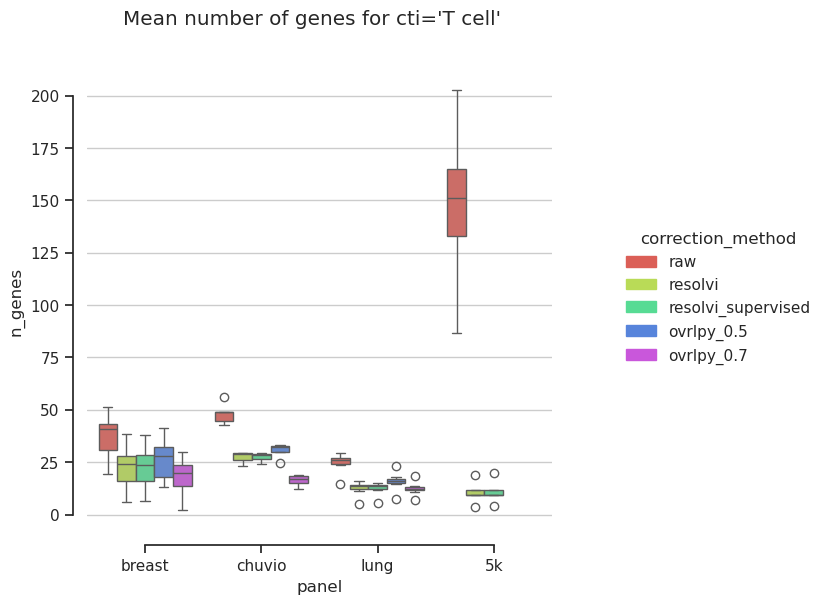

In [ ]:
cti = 'T cell'

df = get_mean_n_genes(ads, correction_methods, labels_key, cti, columns = xenium_levels + ['correction_method','n_genes'])

df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})
    
# plotting params, palette
title = f"Mean number of genes for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(6, 6))
ax = plt.subplot()
g = sns.boxplot(df,x='panel',y='n_genes', 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=order
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

# Plot decontamination strength vs number of genes

In [307]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

# get n_genes df
df_n_genes = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','n_genes'])

# get contamination df
df_contamination = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                    for count_correction_method in correction_methods
                    for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                    }).reset_index()
df_contamination.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df_contamination.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

# merge and filter for segmentation and cell type pair of interest (df_n_genes is only cti specific)
df = pd.merge(df_n_genes,df_contamination,on=xenium_levels+['cti','correction_method'])
df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")

# shorten ovrlpy names
df['correction_method'] = df['correction_method'].replace({
    'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
    'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

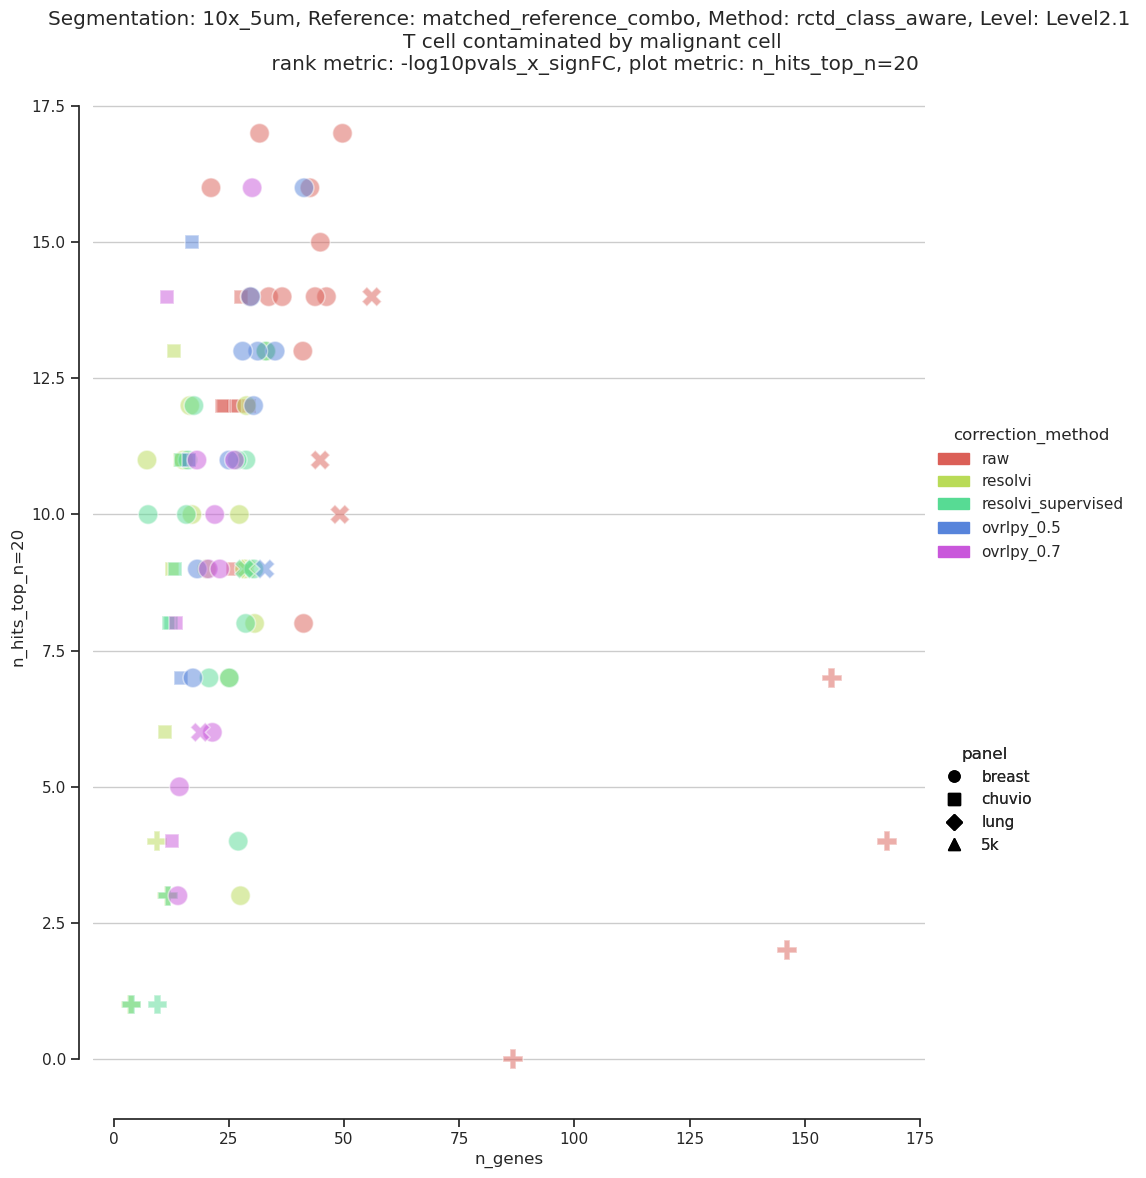

In [328]:


if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
    plot_metric = '-log10pvalue'

# plotting params, palette
title = f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]


# Define marker category (e.g., 'panel')
marker_category = 'panel'
unique_markers = df[marker_category].unique()

# Define marker styles (extend if needed)
marker_styles = ['o', 's', 'D', '^', 'v', 'p', '*', '8', 'h', '+']
if len(unique_markers) > len(marker_styles):
    raise ValueError(f"Not enough marker styles for {len(unique_markers)} markers. Add more styles.")

# Map markers
marker_map = dict(zip(unique_markers, marker_styles))

# Create legend handles for markers
legend_handles_markers = [mlines.Line2D([], [], color='black', marker=marker_map[m], linestyle='None', 
                                        markersize=8, label=m) for m in unique_markers]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(12, 12))
ax = plt.subplot()
g = sns.scatterplot(df,x='n_genes',y=plot_metric, 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                style=marker_category,
                s=200,alpha=.5
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)

# Add legends
legend1 = ax.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.6), 
                     title=hue_correction, frameon=False)
legend2 = ax.legend(handles=legend_handles_markers, loc="center left", bbox_to_anchor=(1, 0.3), 
                     title=marker_category, frameon=False)

# Add both legends to the figure
ax.add_artist(legend1)
ax.add_artist(legend2)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.8, 1])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

In [ ]:

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        df = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                            for count_correction_method in correction_methods
                            for k, v in df_markers_rank_significance_diffexpr[count_correction_method].items()
                            }).reset_index()
        df.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

        df['correction_method'] = df['correction_method'].replace({
            'ovrlpy_correction_signal_integrity_threshold=0.5':'ovrlpy_0.5',
            'ovrlpy_correction_signal_integrity_threshold=0.7':'ovrlpy_0.7'})

        df = df.query(f"segmentation == '{ref_segmentation}' and cti == @cti and ctj == @ctj")

        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        # palette = {u: palette[u] for u in unique_labels}
        palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(6, 6))
        ax = plt.subplot()
        g = sns.boxplot(df,x='panel',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=order
                        )

        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        plt.suptitle(title)
        f.legend(
            handles=legend_handles,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title=hue_correction,
            frameon=False,
        )
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.show()